In [1]:
%%time

from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.solve import solve
from pysme.abund import Abund
from pysme import sme as SME
from pysme import util

from pysme.synthesize import synthesize_spectrum
from astropy.constants import c
from pysme.util import vac2air, air2vac

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import glob
import sys
import os

warnings.filterwarnings('ignore')

CPU times: user 5.49 s, sys: 2.23 s, total: 7.72 s
Wall time: 1min 42s


In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [3]:
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [4]:
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

In [5]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe.csv')
uves['feh'] =uves.fe.values - solar.abund.get_element('Fe') + uves.monh.values

In [6]:
from breidablik.interpolate.spectra import Spectra
from breidablik.interpolate.nlte import Nlte
from scipy.interpolate import CubicSpline
from breidablik.analysis import tools
from breidablik.analysis import read

In [9]:
#
models = Spectra()
nlte = Nlte()

In [10]:
#Li function
def breidablik_li(i, input_row):
    
    
    util.start_logging('logs/elems_limits.dat', level='ERROR')
    try:
        sme = SME_Structure.load('sme_save/UVES_atm_%s.sme' %input_row.spec_id)
    except:
        print(input_row.spec_id)
        return
        
    #Masking and preparing wl/flux data
    f_li_6100 = (sme.wave.data > 6101) & (sme.wave.data < 6106)
    f_li_6700 = (sme.wave.data > 6704) & (sme.wave.data < 6712)
    
    wl_6100, flux_6100, flux_err_6100 = sme.wave.data[f_li_6100], sme.spec.data[f_li_6100], sme.uncs.data[f_li_6100]
    wl_6700, flux_6700, flux_err_6700 = sme.wave.data[f_li_6700], sme.spec.data[f_li_6700], sme.uncs.data[f_li_6700]
    
    wl_6100, wl_6700 = air2vac(wl_6100, 'A')/10., air2vac(wl_6700, 'A')/10.
    flux_6100, flux_6700 = flux_6100 + (1-np.median(flux_6100)), flux_6700 + (1-np.median(flux_6700))
    flux_err_6100, flux_err_6700 = flux_err_6100, flux_err_6700
    
    #Deriving lithium parameters from the line at given teff, logg, monh
    t_eff, log_g, feh = input_row.teff, input_row.logg, input_row.feh
    
    li_abund_6100, li_errs_6100 = models.find_abund(wl_6100, flux_6100, flux_err_6100, t_eff, log_g, feh)
    li_abund_6700, li_errs_6700 = models.find_abund(wl_6700, flux_6700, flux_err_6700, t_eff, log_g, feh)
    
    #Generate Li model for the star
    pred_flux_6100, pred_flux_6700 = models.predict_flux(t_eff, log_g, feh, li_abund_6100), models.predict_flux(t_eff, log_g, feh, li_abund_6700)
    pred_wl = vac2air(read.get_wavelengths() * 10.)
    wl_6100, wl_6700 = vac2air(wl_6100 * 10.), vac2air(wl_6700 * 10.)
    
    f_pred_wl_6100 = (pred_wl > 6101) & (pred_wl < 6106)
    f_pred_wl_6700 = (pred_wl > 6704) & (pred_wl < 6712)
    pred_wl_6100, pred_wl_6700 = pred_wl[f_pred_wl_6100], pred_wl[f_pred_wl_6700]
    pred_flux_6100, pred_flux_6700 = pred_flux_6100[f_pred_wl_6100], pred_flux_6700[f_pred_wl_6700]
    pred_flux_6100, pred_flux_6700 = CubicSpline(pred_wl_6100, pred_flux_6100)(wl_6100), CubicSpline(pred_wl_6700, pred_flux_6700)(wl_6700)
    
    # nlte_corr_6100, nlte_corr_6700 = nlte.nlte_correction(t_eff, log_g, feh, li_abund_6100), nlte.nlte_correction(t_eff, log_g, feh, li_abund_6700)
    
    pd.DataFrame(data=np.vstack((input_row.spec_id, li_abund_6100, li_errs_6100[0], li_errs_6100[1], li_abund_6700, li_errs_6700[0], li_errs_6700[1])).T, 
                 columns=['spec_id', 'li_6100', 'eli_down_6100', 'eli_up_6100', 'li_6700', 'eli_down_6700', 'eli_up_6700']).to_csv('tmp_merged/UVES_li.csv', header=False, index=False, mode='a')
    
    sme = SME_Structure()
    sme.wave = [wl_6100, wl_6700]
    sme.spec = [flux_6100, flux_6700]
    sme.uncs = [flux_err_6100, flux_err_6700]
    sme.synth = [pred_flux_6100, pred_flux_6700]
    sme.teff, sme.logg, sme.monh = t_eff, log_g, feh
    sme.save('sme_save/UVES_li_%s' %input_row.spec_id)
    
    return # li_abund_6100, li_errs_6100[0], li_errs_6100[1], li_abund_6700, li_errs_6700[0], li_errs_6700[1]

In [11]:
# %%time
# li_abund_6100, li_errs_6100, li_errs_6100, li_abund_6700, li_errs_6700, li_errs_6700 = breidablik_li(i = 118, input_row=uves.iloc[118])

In [12]:
# li_abund_6100, li_errs_6100, li_errs_6100

In [13]:
# li_abund_6700, li_errs_6700, li_errs_6700

In [66]:
if os.path.exists('tmp_merged/UVES_li.csv'):
    os.system('rm tmp_merged/UVES_li.csv')

Parallel(n_jobs=-1, verbose=5)(delayed(breidablik_li)(i, input_row) for i, input_row in uves.iterrows());

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 124 out of 160 | elapsed:  1.4min remaining:   23.6s
[Parallel(n_jobs=-1)]: Done 157 out of 160 | elapsed:  1.7min remaining:    2.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.9min finished


In [14]:
#Merge file with UVES one

In [70]:
!sed -i '1i \spec_id,li_6100,eli_down_6100,eli_up_6100,li_6700,eli_down_6700,eli_up_6700' tmp_merged/UVES_li.csv

In [19]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr_n.csv')
uves['feh'] = uves.fe.values + uves.monh.values - solar.abund.get_element('Fe')
li = pd.read_csv('tmp_merged/UVES_li.csv')
uves = uves.merge(right=li, on='spec_id')

In [20]:
uves.sort_values(by='li_6700', ascending=False).spec_id.head(10)

115    6661076122378750208_3572802_012
17     2882976353396129408_3708481_137
18     2882976353396129408_3708481_142
24     3184578612007287680_3708454_141
95     6445869192509584640_3573664_098
22     3067753616067185024_3708457_145
113    6638289946484861184_3573754_117
112    6638289946484861184_3573754_112
12     2666382767566459264_3573733_102
19     2900487695273194880_3708421_134
Name: spec_id, dtype: object

In [21]:
spec_id = '6661076122378750208_3572802_012'
uves.query('spec_id == "%s"' %spec_id)[['source_id', 'teff', 'logg', 'feh', 'li_6700', 'li_6100']]

,source_id,teff,logg,feh,li_6700,li_6100
115,6661076122378750208,4528.761658,1.139871,-2.766027,2.345859,2.1976


In [22]:
A_Li_Sun = 0.96 #Wang+ 3D NLTE
print('A(Li) = %2.2f -- [Li/Fe] = %2.2f' %(uves.query('spec_id == "%s"' %spec_id).li_6700, uves.query('spec_id == "%s"' %spec_id).li_6700 - A_Li_Sun))

A(Li) = 2.35 -- [Li/Fe] = 1.39


In [23]:
#Plotting to make sure we have the right columns

In [24]:
sme = SME_Structure.load('sme_save/UVES_li_%s.sme' %spec_id)

INFO - Loading SME file sme_save/UVES_li_6661076122378750208_3572802_012.sme


In [25]:
wl_6100, wl_6700 = sme.wave[0], sme.wave[1]
flux_6100, flux_6700 = sme.spec[0], sme.spec[1]
eflux_6100, eflux_6700 = sme.uncs[0], sme.uncs[1]
model_6100, model_6700 = sme.synth[0], sme.synth[1]

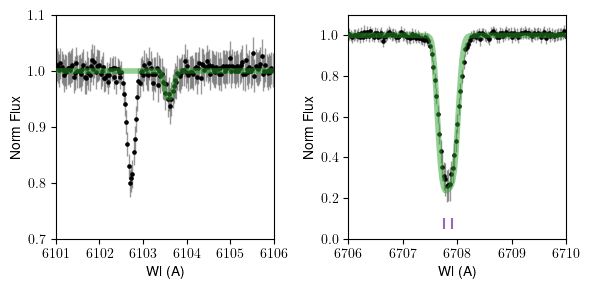

In [26]:
plt.figure(figsize=(6,3), dpi=100)

plt.subplot(1,2,1)
plt.scatter(wl_6100, flux_6100, s=5, color='k')
plt.errorbar(wl_6100, flux_6100, color='k', ms=4, alpha=0.4, fmt='k.', yerr=eflux_6100, lw=1)
plt.plot(wl_6100, model_6100, color='C2', lw=4, alpha=0.5, zorder=9)

plt.vlines(6103.54, 0.55, 0.6, color='C4')
plt.vlines(6103.65, 0.55, 0.6, color='C4')

plt.xlim(6101, 6106)
plt.xlabel('Wl (A)')
plt.ylabel('Norm Flux')
plt.ylim(0.7, 1.1)

plt.subplot(1,2,2)
plt.scatter(wl_6700, flux_6700, s=5, color='k')
plt.errorbar(wl_6700, flux_6700, color='k', ms=4, alpha=0.4, fmt='k.', yerr=eflux_6700, lw=1)
plt.plot(wl_6700, model_6700, color='C2', lw=4, alpha=0.5, zorder=9)

plt.vlines(6707.76, 0.05, 0.1, color='C4')
plt.vlines(6707.91, 0.05, 0.1, color='C4')

plt.xlim(6706, 6710)
plt.xlabel('Wl (A)')
plt.ylabel('Norm Flux')
plt.ylim(0.0, 1.1)

plt.tight_layout()
plt.show()

In [27]:
#Plotting and small analysis

In [28]:
uves['eli_6100'] = 0.5*(uves.eli_up_6100.values + uves.eli_down_6100.values)
uves['eli_6700'] = 0.5*(uves.eli_up_6700.values + uves.eli_down_6700.values)

In [29]:
uves.drop_duplicates(subset=['source_id'], keep='first', inplace=True)

In [30]:
uves['is_limit_li'] = False
uves['is_limit_li'][uves.li_6700.values < 0.35] = True

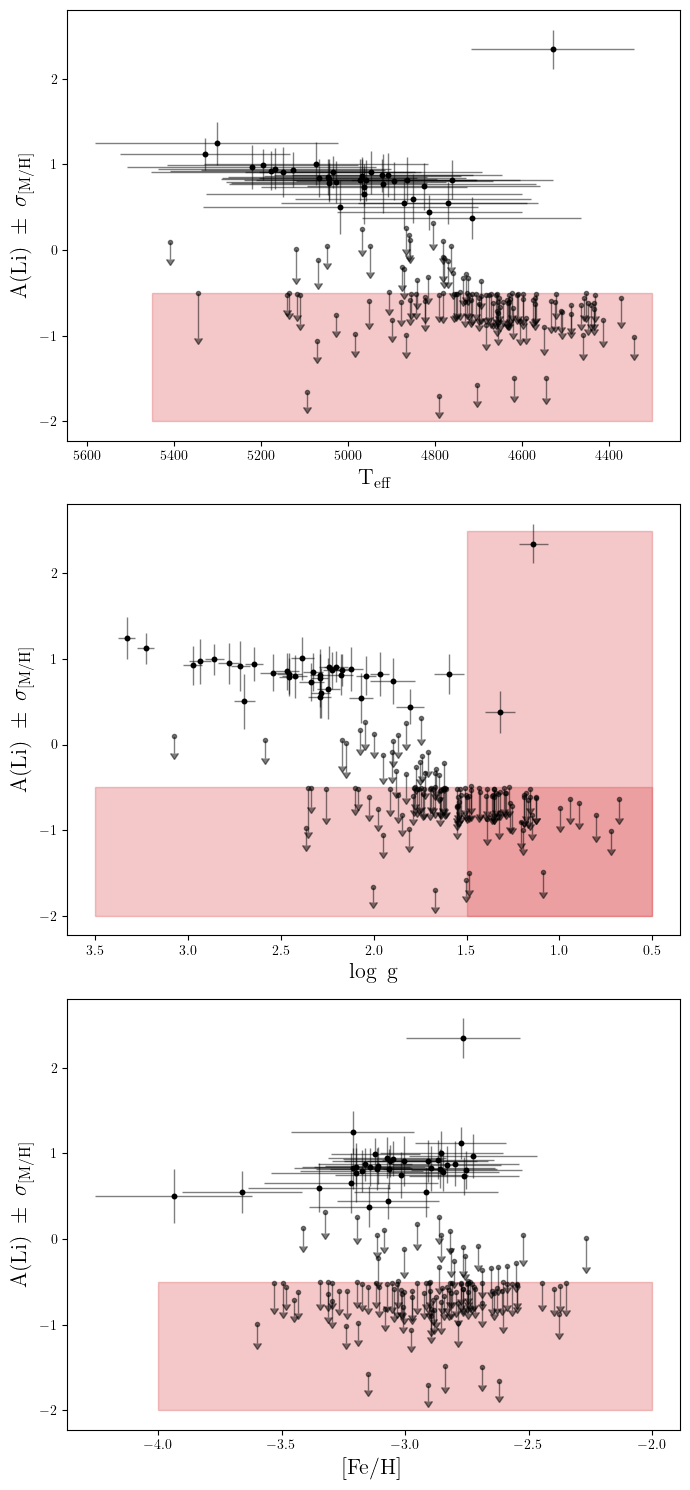

In [31]:
plt.figure(figsize=(7, 15), dpi=100)

plt.subplot(3,1,1)
plt.scatter(uves.query('is_limit_li == False').teff.values, uves.query('is_limit_li == False').li_6700.values, s=10, color='k', zorder=9)
plt.errorbar(uves.query('is_limit_li == False').teff.values, uves.query('is_limit_li == False').li_6700.values, fmt='k.', 
             xerr=uves.query('is_limit_li == False').eteff_sme.values, yerr=uves.query('is_limit_li == False').emonh_sme.values, lw=1, alpha=0.5)
plt.errorbar(uves.query('is_limit_li == True').teff.values, uves.query('is_limit_li == True').li_6700.values, fmt='k.', 
             lw=1, alpha=0.5, yerr=uves.query('is_limit_li == True').emonh_sme.values, 
             uplims=np.ones_like(uves.query('is_limit_li == True').eteff_sme.values).astype(bool))

plt.fill_between(x = [5450, 4300], y1 = -2, y2 = -0.5, zorder=0, color='C3', alpha=0.25)
# plt.scatter(uves.query('logg < 3.0 and logg > 2.6 and li_6700 > 0.75').teff.values, uves.query('logg < 3.0 and logg > 2.6 and li_6700 > 0.75').li_6700.values, s=25, color='C4', zorder=9, edgecolors='k')
plt.gca().invert_xaxis()
plt.xlabel(r'${\rm T_{eff}}$', size=16)
plt.ylabel(r'${\rm A(Li)\ \pm\ \sigma_{[M/H]} }$', size=16)

plt.subplot(3,1,2)
plt.scatter(uves.query('is_limit_li == False').logg.values, uves.query('is_limit_li == False').li_6700.values, s=10, color='k', zorder=9)
plt.errorbar(uves.query('is_limit_li == False').logg.values, uves.query('is_limit_li == False').li_6700.values, fmt='k.', 
             xerr=uves.query('is_limit_li == False').elogg_sme.values, yerr=uves.query('is_limit_li == False').emonh_sme.values, lw=1, alpha=0.5)
plt.errorbar(uves.query('is_limit_li == True').logg.values, uves.query('is_limit_li == True').li_6700.values, fmt='k.', 
             lw=1, alpha=0.5, yerr=uves.query('is_limit_li == True').emonh_sme.values, 
             uplims=np.ones_like(uves.query('is_limit_li == True').elogg_sme.values).astype(bool))

plt.fill_between(x = [3.5, 0.5], y1 = -2, y2 = -0.5, zorder=0, color='C3', alpha=0.25)
plt.fill_betweenx(y = [-2, 2.5], x1 = 0.5, x2 = 1.5, zorder=0, color='C3', alpha=0.25)
# plt.scatter(uves.query('logg < 3.0 and logg > 2.6 and li_6700 > 0.75').logg.values, uves.query('logg < 3.0 and logg > 2.6 and li_6700 > 0.75').li_6700.values, s=25, color='C4', zorder=9, edgecolors='k')
# plt.scatter(uves.query('feh < -3.3').logg.values, uves.query('feh < -3.3').li_6700.values, s=50, color='g', zorder=9, edgecolors='k')
plt.gca().invert_xaxis()

plt.xlabel(r'${\rm \log\ g}$', size=16)
plt.ylabel(r'${\rm A(Li)\ \pm\ \sigma_{[M/H]} }$', size=16)

plt.subplot(3,1,3)
plt.scatter(uves.query('is_limit_li == False').feh.values, uves.query('is_limit_li == False').li_6700.values, s=10, color='k', zorder=9)
plt.errorbar(uves.query('is_limit_li == False').feh.values, uves.query('is_limit_li == False').li_6700.values, fmt='k.', 
             xerr=uves.query('is_limit_li == False').emonh_sme.values, yerr=uves.query('is_limit_li == False').emonh_sme.values, lw=1, alpha=0.5)
plt.errorbar(uves.query('is_limit_li == True').feh.values, uves.query('is_limit_li == True').li_6700.values, fmt='k.', 
             lw=1, alpha=0.5, yerr=uves.query('is_limit_li == True').emonh_sme.values, 
             uplims=np.ones_like(uves.query('is_limit_li == True').emonh_sme.values).astype(bool))

plt.fill_between(x = [-4.0, -2.0], y1 = -2, y2 = -0.5, zorder=0, color='C3', alpha=0.25)
# plt.scatter(uves.query('logg < 3.0 and logg > 2.6 and li_6700 > 0.75').feh.values, uves.query('logg < 3.0 and logg > 2.6 and li_6700 > 0.75').li_6700.values, s=25, color='C4', zorder=9, edgecolors='k')
plt.xlabel(r'${\rm [Fe/H]}$', size=16)
plt.ylabel(r'${\rm A(Li)\ \pm\ \sigma_{[M/H]} }$', size=16)

plt.tight_layout()
plt.savefig('plots/uves_li_atm.pdf', dpi=100)
plt.show()

In [107]:
uves = uves.query('ec_sme < 1 and en_nh_sme < 1')

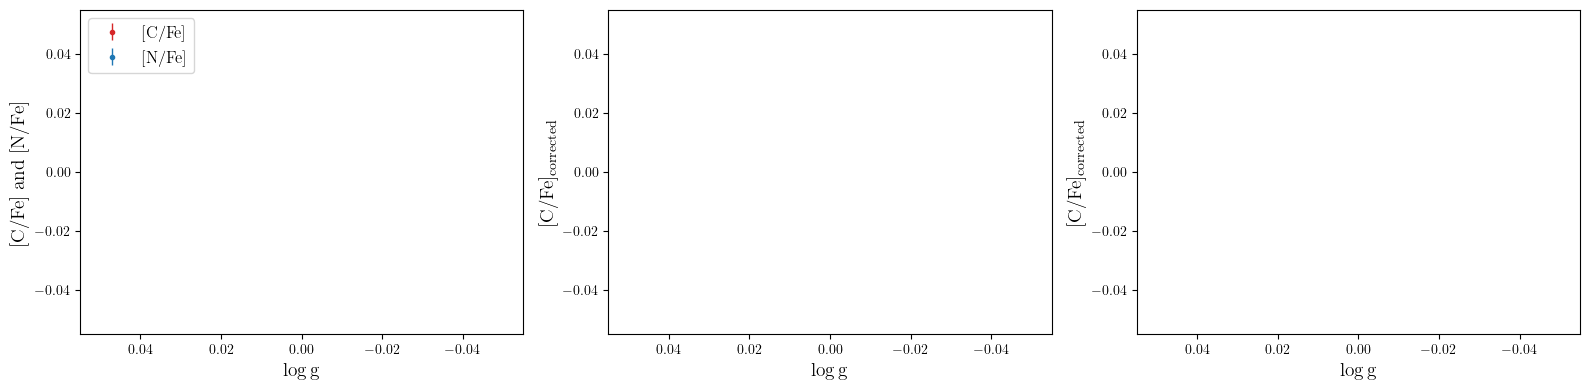

In [108]:
plt.figure(figsize=(16,4), dpi=100)

plt.subplot(1,3,1)
# plt.scatter(uves.logg.values[uves.ec_sme.values < 1], uves.c.values[uves.ec_sme.values < 1] - solar.abund.get_element('C'), color='C3', s=5)
plt.errorbar(uves.logg.values, uves.c.values - solar.abund.get_element('C'), yerr=uves.ec_sme.values, 
             fmt='r.', color='C3', lw=1, zorder=9, label=r'${\rm [C/Fe]}$')
# plt.scatter(uves.logg.values[uves.is_limit_n_nh.values], uves.n_nh.values[uves.is_limit_n_nh.values] - solar.abund.get_element('N'), color='C0', s=5)
plt.errorbar(uves.logg.values, uves.n_nh.values - solar.abund.get_element('N'), fmt='b.', lw=1, color='C0', yerr=uves.en_nh_sme.values, zorder=8, label=r'${\rm [N/Fe]}$')
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize=12)
plt.xlabel(r'${\rm \log{g}}$', size=14)
plt.ylabel(r'${\rm [C/Fe]\ and\ [N/Fe]}$', size=14)

plt.subplot(1,3,2)
plt.errorbar(uves.logg.values, uves.c.values - uves.n_nh.values, yerr=uves.ec_sme.values, fmt='r.', color='C3', lw=1)
plt.gca().invert_xaxis()
plt.xlabel(r'${\rm \log{g}}$', size=14)
plt.ylabel(r'${\rm [C/Fe]_{corrected}}$', size=14)

plt.subplot(1,3,3)
plt.errorbar(uves.logg.values, uves.c.values + uves.carbon_correction_03.values - solar.abund.get_element('C'), yerr=uves.ec_sme.values, fmt='r.', color='C3', lw=1)
plt.gca().invert_xaxis()
plt.xlabel(r'${\rm \log{g}}$', size=14)
plt.ylabel(r'${\rm [C/Fe]_{corrected}}$', size=14)

plt.tight_layout()
plt.savefig('plots/UVES_CNFe_logg.pdf')
plt.show()

In [344]:
li_plateau = uves.query('logg < 3.0 and logg > 2.6 and li_6700 > 0.75')

In [347]:
print('Li small plateau: %2.3f +- %2.3f (Nstars = %d)' %(np.mean(li_plateau.li_6700.values), np.std(li_plateau.li_6700.values), li_plateau.spec_id.size))

Li small plateau: 0.949 +- 0.027 (Nstars = 6)


In [172]:
from astropy.table import Table

In [181]:
%%time
galah_dr4 = Table.read('../translator/galah_dr4_allstar_240705.fits').to_pandas()
galah_dr4.dropna(subset=['logg', 'a_li'], inplace=True)

CPU times: user 5.22 s, sys: 273 ms, total: 5.49 s
Wall time: 5.51 s


In [171]:
#OLD CODE FROM HERE

In [ ]:
# J/A+A/503/545/table4 Lind Lithium 2009

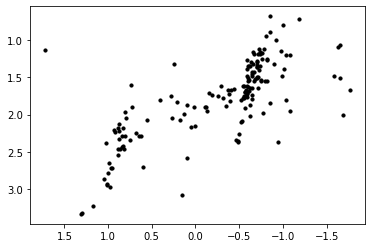

In [33]:
plt.scatter(uves.li_6700.values + uves.li_6700_nlte_corr.values, uves.logg.values, s=10, color='k')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

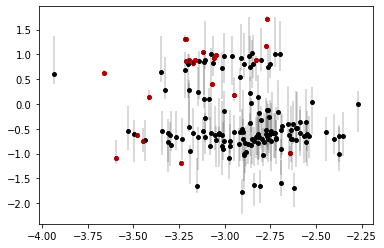

In [27]:
plt.scatter(uves.fe.values + uves.monh.values - solar.abund.get_element('Fe'), uves.li_6700.values + uves.li_6700_nlte_corr.values, s=15, color='k')
plt.errorbar(uves.fe.values + uves.monh.values - solar.abund.get_element('Fe'), uves.li_6700.values  + uves.li_6700_nlte_corr.values, fmt='k.', 
             yerr=10*np.array([uves.eli_down_6700.values, np.abs(uves.eli_up_6700.values)]), alpha=0.2)
f_eli = (uves.eli_6700.values < 0.03)
plt.scatter(uves.fe.values[f_eli] + uves.monh.values[f_eli] - solar.abund.get_element('Fe'), uves.li_6700.values[f_eli]  + uves.li_6700_nlte_corr.values[f_eli], s=15, color='r')

plt.show()

In [ ]:
uves.query('logg ')